In [ ]:
# ==========================================
# SCRIPT KOREKSI BIAS: TEMPORAL ANALYSIS (SEASONAL)
# ==========================================
# Penulis: Mahasiswa Geografi Lingkungan
# Metode: Seasonal/Temporal Scaling (12 Monthly Factors)
# Deskripsi: Menghitung faktor koreksi spesifik untuk setiap bulan (Jan-Des)
#            untuk menangkap pola variabilitas musiman.
# ==========================================

# 1. INSTALL LIBRARY
!pip install rasterio geopandas shapely matplotlib scikit-learn pandas numpy seaborn tqdm folium

import os
import glob
import numpy as np
import pandas as pd
import rasterio
from rasterio.mask import mask
import geopandas as gpd
from shapely.geometry import box
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from google.colab import drive
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore')

In [ ]:
# ==========================================
# BAGIAN 1: SETUP & KONFIGURASI
# ==========================================

# Mount Google Drive
drive.mount('/content/drive')

# --- DIREKTORI DATA ---
BASE_DIR = '/content/drive/My Drive/Colab Notebooks/Skripsi/'
CHIRPS_DIR = os.path.join(BASE_DIR, 'CHIRPS v3/')
ADMIN_PATH = os.path.join(BASE_DIR, 'Batas Adm Jambi/Adm_Jambi_Prov.shp')
CSV_DIR = os.path.join(BASE_DIR, 'Data Stasiun BWS Sumatera VI/')

# Output Directory
output_dir = os.path.join(CHIRPS_DIR, 'bias_corrected_temporal')
os.makedirs(output_dir, exist_ok=True)

# Rentang wilayah
bbox = box(100.75, -2.75, 104.75, -0.5)
bbox_gdf = gpd.GeoDataFrame({'geometry': [bbox]}, crs='EPSG:4326')

# --- DAFTAR STASIUN ---
bias_stations = [
    "Koto Limau Sering", "Semurup", "Sipin", "Siulak Deras",
    "Dendang", "Pulau Tengah", "Tamiai"
]

validation_stations = [
    "Bukit Bulan",
    "Muara Tembesi",
    "Rantau Pandan",
    "Sungai Manau",
    "Tanjung Genting",
    "Muaro Imat",
    "Sungai Bengkal"
]

station_coords = {
    "Koto Limau Sering": (101.366300, -2.063383),
    "Semurup": (101.378350, -2.001750),
    "Sipin": (103.596750, -1.610600),
    "Siulak Deras": (101.297850, -1.936050),
    "Dendang": (103.948100, -1.190800),
    "Pulau Tengah": (101.463533, -2.169750),
    "Tamiai": (101.643800, -2.186933),
    "Batang Asai": (102.285631, -2.492758),
    "Biuku Tanjung": (102.201683, -2.123467),
    "Bukit Bulan": (102.639417, -2.517517),
    "Hiang": (101.477800, -2.074217),
    "Jujuhan": (101.766217, -1.328300),
    "Kersik Tuo": (101.282533, -1.779867),
    "Pulau Musang": (102.100717, -1.157717),
    "Mess Bungo": (102.330650, -1.494717),
    "Muara Jernih": (102.166800, -1.950067),
    "Muara Tembesi": (103.127017, -1.719333),
    "Pulau Lintang": (102.592700, -2.280883),
    "Rantau Pandan": (101.968817, -1.621217),
    "Rimbo Bujang": (102.088833, -1.319517),
    "Senamat": (102.330650, -1.643583),
    "Suak Kandis": (104.053117, -1.374000),
    "Sungai Manau": (101.983400, -2.114817),
    "Tanjung Genting": (103.161200, -1.938300),
    "Durian Luncuk": (102.995683, -1.880150),
    "Gapura Suci": (102.285383, -1.699950),
    "Lempur": (101.627683, -2.248867),
    "Muaro Imat": (101.719850, -2.225333),
    "Pamenang": (102.512817, -2.112200),
    "Pasir Putih": (103.643200, -1.622550),
    "Pauh": (102.820633, -2.133417),
    "Sungai Bengkal": (102.723933, -1.550633),
    "Singkut": (102.713633, -2.506200)
}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ==========================================
# BAGIAN 2: FUNGSI UTILITAS
# ==========================================

def clip_raster_to_bbox(input_path, bbox_geom):
    with rasterio.open(input_path) as src:
        out_image, out_transform = mask(src, bbox_geom.geometry, crop=True)
        out_meta = src.meta.copy()
        out_meta.update({
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })
    return out_image[0], out_meta

def extract_chirps_at_point(raster, transform, lon, lat):
    row, col = rasterio.transform.rowcol(transform, lon, lat)
    try:
        val = raster[row, col]
        return val if val != -9999 else np.nan
    except IndexError:
        return np.nan

def load_station_csv(csv_dir):
    bulan_mapping = {'Januari': '01', 'Februari': '02', 'Maret': '03', 'April': '04',
                     'Mei': '05', 'Juni': '06', 'Juli': '07', 'Agustus': '08',
                     'September': '09', 'Oktober': '10', 'November': '11', 'Desember': '12'}
    station_data = {}
    csv_files = glob.glob(os.path.join(csv_dir, '*.csv'))

    if not csv_files:
        print("[ERROR] Tidak ada file CSV ditemukan!")
        return {}

    for csv_file in csv_files:
        nama = os.path.basename(csv_file).replace('.csv', '')
        try:
            df = pd.read_csv(csv_file, index_col=0)
            df.replace("-", np.nan, inplace=True)
            df = df.apply(pd.to_numeric, errors='coerce')
            df = df.stack().reset_index()
            df.columns = ['Bulan', 'Tahun', 'CurahHujan']
            df['BulanAngka'] = df['Bulan'].map(bulan_mapping)
            df['Tanggal'] = pd.to_datetime(df['Tahun'].astype(str) + "-" + df['BulanAngka'] + "-01")
            df.set_index('Tanggal', inplace=True)
            station_data[nama] = df[['CurahHujan']].sort_index()
        except:
            pass
    return station_data

In [ ]:
# ==========================================
# BAGIAN 3: PROSES UTAMA (TEMPORAL ANALYSIS)
# ==========================================

print("--- Memuat Data ---")
station_data = load_station_csv(CSV_DIR)
chirps_files = sorted(glob.glob(os.path.join(CHIRPS_DIR, 'chirps-v3.0.*.tif')))
validasi_df = pd.DataFrame()

# ---------------------------------------------------------
# TAHAP 1: MEMBANGUN PROFIL MUSIMAN (Training)
# ---------------------------------------------------------
print("\n[TAHAP 1] Menghitung Faktor Musiman (Training)...")
print("Mengelompokkan data berdasarkan Bulan (Jan-Des)...")

# Struktur penyimpanan: monthly_data[bulan_angka] = {'obs': [], 'sat': []}
monthly_data = {m: {'obs': [], 'sat': []} for m in range(1, 13)}

# Loop sampling data
for file_path in tqdm(chirps_files, desc="Sampling Data"):
    try:
        filename = os.path.basename(file_path)
        parts = filename.split('.')
        date = pd.to_datetime(f"{parts[2]}-{parts[3]}-01")
        month_idx = date.month  # 1 - 12
    except:
        continue

    # Baca raster windowed
    with rasterio.open(file_path) as src:
        out_image, out_transform = mask(src, bbox_gdf.geometry, crop=True)
        raster_data = out_image[0]

    for stasiun in bias_stations:
        if stasiun in station_data:
            try:
                obs_val = station_data[stasiun].reindex([date])['CurahHujan'].values[0]
                lon, lat = station_coords[stasiun]
                sat_val = extract_chirps_at_point(raster_data, out_transform, lon, lat)

                if not np.isnan(obs_val) and not np.isnan(sat_val) and sat_val >= 0:
                    monthly_data[month_idx]['obs'].append(obs_val)
                    monthly_data[month_idx]['sat'].append(sat_val)
            except:
                continue

# Menghitung Faktor Koreksi per Bulan (Seasonal Factors)
seasonal_factors = {}
print("\n--- FAKTOR KOREKSI MUSIMAN (TEMPORAL) ---")
for m in range(1, 13):
    obs_sum = np.sum(monthly_data[m]['obs'])
    sat_sum = np.sum(monthly_data[m]['sat'])

    # Hitung rasio (Obs / Sat)
    if sat_sum > 0:
        factor = obs_sum / sat_sum
    else:
        factor = 1.0 # Default jika tidak ada hujan satelit

    seasonal_factors[m] = factor
    nama_bulan = pd.to_datetime(f"2023-{m}-01").strftime('%B')
    print(f"Bulan {m} ({nama_bulan}): Faktor = {factor:.4f} (Sampel: {len(monthly_data[m]['obs'])})")
print("-------------------------------------------\n")

# ---------------------------------------------------------
# TAHAP 2: MENERAPKAN KOREKSI & VALIDASI
# ---------------------------------------------------------
print("[TAHAP 2] Menerapkan Koreksi & Validasi...")

for file_path in tqdm(chirps_files, desc="Processing Raster"):
    filename = os.path.basename(file_path)
    try:
        parts = filename.split('.')
        date = pd.to_datetime(f"{parts[2]}-{parts[3]}-01")
        month_idx = date.month
    except:
        continue

    # 1. Baca Raster
    raster, meta = clip_raster_to_bbox(file_path, bbox_gdf)

    # 2. TERAPKAN KOREKSI MUSIMAN
    # Ambil faktor sesuai bulan file tersebut
    current_factor = seasonal_factors[month_idx]

    corrected_raster = raster * current_factor
    corrected_raster = np.maximum(corrected_raster, 0)

    # 3. Validasi
    for stasiun in validation_stations:
        obs_val = np.nan
        raw_val = np.nan
        corr_val = np.nan

        if stasiun in station_data:
            try:
                val = station_data[stasiun].reindex([date])['CurahHujan'].values[0]
                if not np.isnan(val): obs_val = val
            except: pass

        if stasiun in station_coords:
            lon, lat = station_coords[stasiun]
            raw_val = extract_chirps_at_point(raster, meta['transform'], lon, lat)
            corr_val = extract_chirps_at_point(corrected_raster, meta['transform'], lon, lat)

        if not (np.isnan(obs_val) and np.isnan(raw_val)):
            entry = pd.DataFrame([{
                "Stasiun": stasiun,
                "Tanggal": date,
                "Observed": obs_val,
                "Raw": raw_val,
                "Corrected": corr_val,
                "Month": month_idx,
                "Seasonal_Factor": current_factor
            }])
            validasi_df = pd.concat([validasi_df, entry], ignore_index=True)

# Simpan Data Validasi
validasi_df.sort_values(['Stasiun', 'Tanggal'], inplace=True)
validasi_df.to_csv(os.path.join(output_dir, 'validasi_temporal_raw.csv'), index=False)

--- Memuat Data ---

[TAHAP 1] Menghitung Faktor Musiman (Training)...
Mengelompokkan data berdasarkan Bulan (Jan-Des)...


Sampling Data: 100%|██████████| 144/144 [04:48<00:00,  2.00s/it]



--- FAKTOR KOREKSI MUSIMAN (TEMPORAL) ---
Bulan 1 (January): Faktor = 0.7401 (Sampel: 84)
Bulan 2 (February): Faktor = 0.9047 (Sampel: 84)
Bulan 3 (March): Faktor = 0.7770 (Sampel: 84)
Bulan 4 (April): Faktor = 0.8198 (Sampel: 84)
Bulan 5 (May): Faktor = 0.8868 (Sampel: 84)
Bulan 6 (June): Faktor = 0.9335 (Sampel: 84)
Bulan 7 (July): Faktor = 0.8708 (Sampel: 84)
Bulan 8 (August): Faktor = 0.8114 (Sampel: 84)
Bulan 9 (September): Faktor = 0.9133 (Sampel: 84)
Bulan 10 (October): Faktor = 0.8588 (Sampel: 84)
Bulan 11 (November): Faktor = 0.9211 (Sampel: 84)
Bulan 12 (December): Faktor = 0.7908 (Sampel: 84)
-------------------------------------------

[TAHAP 2] Menerapkan Koreksi & Validasi...


Processing Raster: 100%|██████████| 144/144 [00:27<00:00,  5.31it/s]


In [ ]:
# ==========================================
# BAGIAN 4: HITUNG METRIK & VISUALISASI
# ==========================================
print("\n--- Menghitung Indikator Statistik ---")
final_metrics = []

for stasiun in validation_stations:
    subset = validasi_df[validasi_df['Stasiun'] == stasiun]
    stats = {
        "Stasiun": stasiun,
        "NSE_Raw": np.nan, "NSE_Corrected": np.nan,
        "R_Raw": np.nan, "R_Corrected": np.nan,
        "RSR_Raw": np.nan, "RSR_Corrected": np.nan
    }

    if not subset.empty:
        obs = subset["Observed"].values
        raw = subset["Raw"].values
        corr = subset["Corrected"].values
        mask_raw = ~np.isnan(obs) & ~np.isnan(raw)
        mask_corr = ~np.isnan(obs) & ~np.isnan(corr)

        def calc_stats(o, p):
            if len(o) < 2: return np.nan, np.nan, np.nan
            r_val, _ = pearsonr(o, p)
            num = np.sum((o - p)**2)
            den = np.sum((o - np.mean(o))**2)
            nse = 1 - (num / den) if den != 0 else np.nan
            rmse = np.sqrt(mean_squared_error(o, p))
            stdev = np.std(o)
            rsr = rmse / stdev if stdev != 0 else np.nan
            return nse, r_val, rsr

        stats["NSE_Raw"], stats["R_Raw"], stats["RSR_Raw"] = calc_stats(obs[mask_raw], raw[mask_raw])
        stats["NSE_Corrected"], stats["R_Corrected"], stats["RSR_Corrected"] = calc_stats(obs[mask_corr], corr[mask_corr])

    final_metrics.append(stats)

summary = pd.DataFrame(final_metrics)
print(summary.head().to_string())
summary.to_csv(os.path.join(output_dir, 'Hasil_Validasi_Temporal_NSE_R_RSR.csv'), index=False)


--- Menghitung Indikator Statistik ---
           Stasiun   NSE_Raw  NSE_Corrected     R_Raw  R_Corrected   RSR_Raw  RSR_Corrected
0      Bukit Bulan  0.052189       0.176267  0.491433     0.464492  0.973556       0.907597
1    Muara Tembesi -5.723833      -2.876134  0.542688     0.566352  2.593036       1.968790
2    Rantau Pandan  0.106813       0.290852  0.564325     0.582169  0.945086       0.842109
3     Sungai Manau -0.350546      -0.007393  0.368643     0.385616  1.162130       1.003690
4  Tanjung Genting -0.706896      -0.171740  0.407449     0.409172  1.306482       1.082469


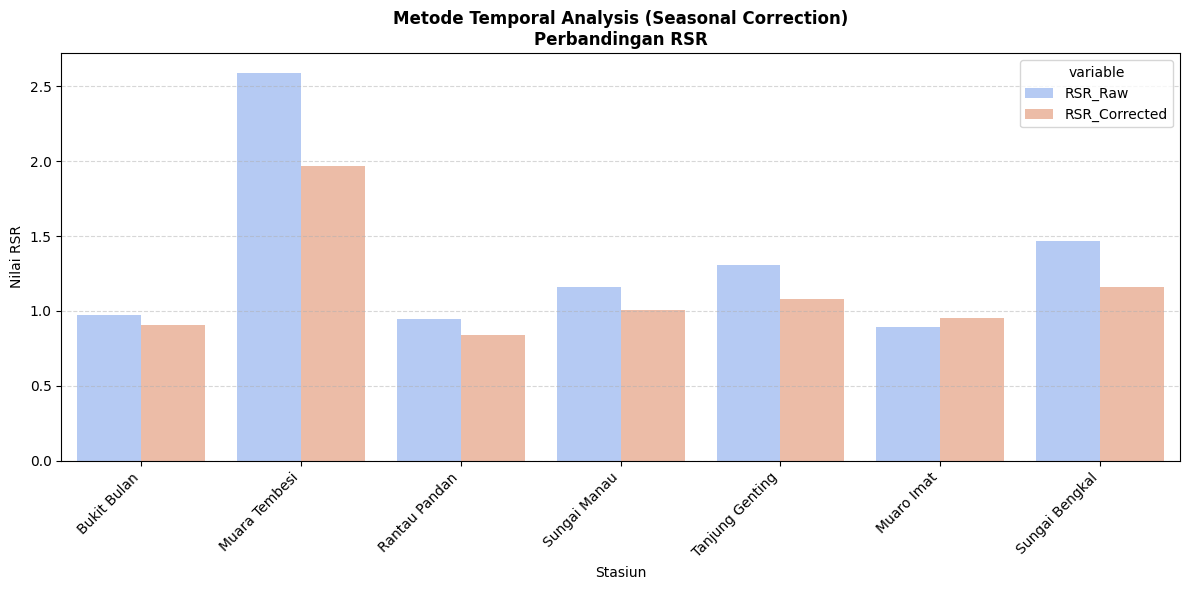

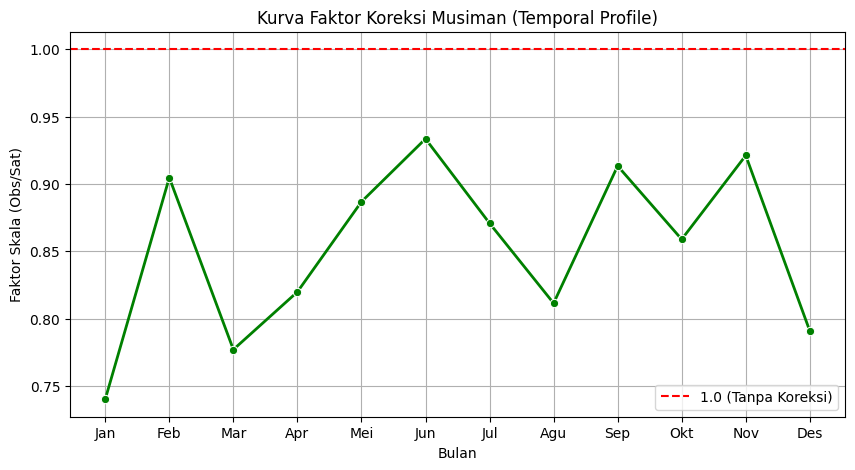

In [ ]:
# Visualisasi 1: Barplot RSR
plt.figure(figsize=(12, 6))
plot_data = summary.melt(id_vars='Stasiun', value_vars=['RSR_Raw', 'RSR_Corrected'])
sns.barplot(data=plot_data, x='Stasiun', y='value', hue='variable', palette='coolwarm')
plt.title('Metode Temporal Analysis (Seasonal Correction)\nPerbandingan RSR', fontweight='bold')
plt.ylabel('Nilai RSR')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Visualisasi 2: Profil Faktor Musiman
factors_df = pd.DataFrame(list(seasonal_factors.items()), columns=['Bulan', 'Faktor'])
plt.figure(figsize=(10, 5))
sns.lineplot(data=factors_df, x='Bulan', y='Faktor', marker='o', color='green', linewidth=2)
plt.axhline(1, color='red', linestyle='--', label='1.0 (Tanpa Koreksi)')
plt.xticks(range(1,13), ['Jan','Feb','Mar','Apr','Mei','Jun','Jul','Agu','Sep','Okt','Nov','Des'])
plt.title('Kurva Faktor Koreksi Musiman (Temporal Profile)')
plt.ylabel('Faktor Skala (Obs/Sat)')
plt.grid(True)
plt.legend()
plt.show()